In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Librerías de Machine Learning
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

# Configuración visual
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
#drive.mount('/content/drive')
print("✅ Celda 1: Librerías cargadas (MODO OFFLINE).")

✅ Celda 1: Librerías cargadas (MODO OFFLINE).


In [2]:
# --- CONFIGURACIÓN DE RUTA ---
# Ajusta esta ruta a donde tengas tu archivo .db
db_path = 'nba_stats.db'

print("📥 Cargando datos históricos y recientes desde SQL...")

conn = sqlite3.connect(db_path)
query = """
SELECT
    info.player, s.season, s.team, s.age, s.pos AS posicion, info.ht_in_in AS altura,
    pg.g AS partidos, pg.mp_per_game AS minutos, pg.pts_per_game AS puntos,
    pg.trb_per_game AS rebotes, pg.ast_per_game AS asistencias, pg.stl_per_game AS robos,
    pg.blk_per_game AS bloqueos, pg.tov_per_game AS perdidas, pg.x3p_per_game AS triples_anotados,
    pg.fga_per_game AS intentos_tiro,
    adv.per AS eficiencia, adv.usg_percent AS uso, adv.ts_percent AS tiro_verdadero, adv.bpm AS box_plus_minus,
    info.player_id
FROM Player_Career_Info info
JOIN Player_Per_Game pg ON info.player_id = pg.player_id
JOIN Advanced adv ON info.player_id = adv.player_id AND pg.season = adv.season
JOIN Player_Season_Info s ON info.player_id = s.player_id AND pg.season = s.season
WHERE s.season >= 2018
"""
# Nota: Quitamos el filtro de fecha final para que traiga todo lo que tenga tu BD
df = pd.read_sql_query(query, conn)
conn.close()

print(f"✅ Celda 2: Dataset cargado desde SQL ({df.shape[0]} filas).")

📥 Cargando datos históricos y recientes desde SQL...
✅ Celda 2: Dataset cargado desde SQL (22425 filas).


In [3]:
# 1. Conversión Numérica
cols_numericas = ['age', 'altura', 'partidos', 'minutos', 'puntos', 'rebotes', 'asistencias', 'robos', 'bloqueos', 'perdidas', 'triples_anotados', 'intentos_tiro', 'eficiencia', 'uso', 'tiro_verdadero', 'box_plus_minus']
for col in cols_numericas:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.fillna(0)

In [4]:
# 2. Filtro de Calidad
# Bajamos a 5 partidos para no perder Rookies o jugadores traspasados recientemente
df = df[ (df['partidos'] >= 5) & (df['minutos'] >= 8.0) ]

In [5]:
# 3. Deduplicación (Lógica Local)
# Ordenamos por partidos descendente. Si un jugador tiene 2 equipos en 2025,
# nos quedamos con el que tenga más partidos jugados (mejor muestra estadística).
if 'player_id' in df.columns:
    df = df.sort_values('partidos', ascending=False).drop_duplicates(subset=['player_id', 'season'], keep='first')
else:
    df = df.sort_values('partidos', ascending=False).drop_duplicates(subset=['player', 'season'], keep='first')

In [6]:
# 4. Sanitización de Texto
for col in ['player', 'team', 'posicion']:
    df[col] = df[col].astype(str).str.strip()

In [7]:
# 5. Borrado de ID
if 'player_id' in df.columns:
    df = df.drop(columns=['player_id'])

In [8]:
# 6. One-Hot Encoding
df = pd.get_dummies(df, columns=['team', 'posicion'], prefix=['team', 'pos'], dtype=int)

print(f"✅ Celda 3: Datos limpios y procesados. Filas finales: {df.shape[0]}")

✅ Celda 3: Datos limpios y procesados. Filas finales: 3933


In [9]:
# 7. GUARDAR CSV FINAL EN TU DRIVE 💾
# Usamos la misma ruta base donde tienes tu base de datos
ruta_guardado = 'nba_datos_limpios.csv'

try:
    df.to_csv(ruta_guardado, index=False)
    print(f"✅ Celda 3 Completada.")
    print(f"📊 Filas finales: {df.shape[0]}")
    print(f"💾 EXCELENTE: Archivo guardado exitosamente en: {ruta_guardado}")
except Exception as e:
    print(f"❌ Error al guardar en Drive: {e}")
    print("Asegúrate de que la carpeta 'NBA_stats' existe en tu Drive.")

✅ Celda 3 Completada.
📊 Filas finales: 3933
💾 EXCELENTE: Archivo guardado exitosamente en: nba_datos_limpios.csv


In [10]:
# 1. Definir X e y
cols_drop = ['player', 'season', 'puntos', 'rebotes', 'asistencias', 'robos', 'bloqueos', 'triples_anotados', 'perdidas', 'intentos_tiro']
X = df.drop(columns=cols_drop, errors='ignore')
y = df['puntos']

# 2. Split y Escalado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Entrenamiento con Historial
model = SGDRegressor(loss='huber', max_iter=1, tol=None, penalty='l2', alpha=0.001, learning_rate='adaptive', eta0=0.01, random_state=42, warm_start=True)
train_loss, val_loss = [], []

print("⚙️ Celda 4: Entrenando modelo (50 épocas)...")
for _ in range(50):
    model.fit(X_train_scaled, y_train)
    train_loss.append(mean_absolute_error(y_train, model.predict(X_train_scaled)))
    val_loss.append(mean_absolute_error(y_test, model.predict(X_test_scaled)))

⚙️ Celda 4: Entrenando modelo (50 épocas)...


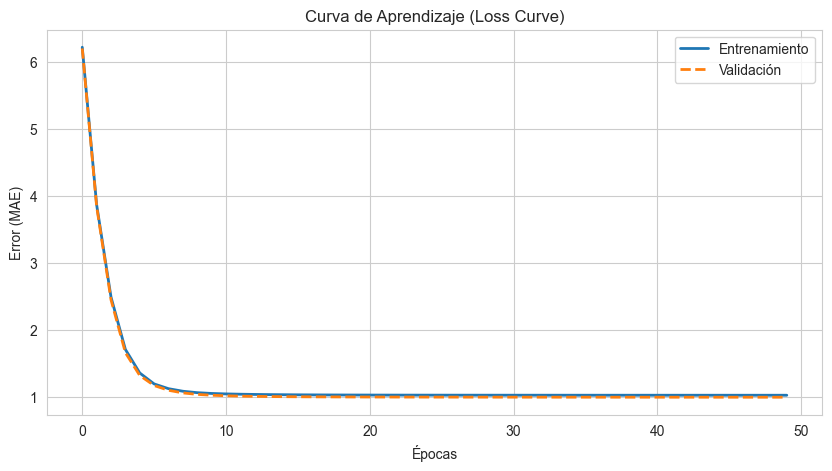

In [11]:
# 4. Gráfica de Pérdida
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Entrenamiento', linewidth=2)
plt.plot(val_loss, label='Validación', linewidth=2, linestyle='--')
plt.title("Curva de Aprendizaje (Loss Curve)")
plt.xlabel("Épocas"); plt.ylabel("Error (MAE)")
plt.legend(); plt.grid(True); plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Hacer predicciones finales en el set de prueba
y_pred = model.predict(X_test_scaled)

# 2. Calcular todas las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 3. Reporte Profesional
print("\n" + "="*40)
print("📊 REPORTE FINAL DE RENDIMIENTO")
print("="*40)
print(f"🎯 MAE (Error Absoluto Medio):  +/- {mae:.2f} Puntos")
print(f"   -> Interpretación: El modelo suele fallar por {mae:.1f} puntos arriba o abajo.")
print("-" * 40)
print(f"📉 RMSE (Raíz Error Cuadrático):    {rmse:.2f} Puntos")
print(f"   -> Interpretación: Penaliza más los fallos grandes (outliers).")
print("-" * 40)
print(f"📈 R2 Score (Precisión Global):     {r2:.4f} (Máx 1.0)")
print(f"   -> Interpretación: El modelo explica el {r2*100:.1f}% del comportamiento del jugador.")
print("="*40)


📊 REPORTE FINAL DE RENDIMIENTO
🎯 MAE (Error Absoluto Medio):  +/- 1.00 Puntos
   -> Interpretación: El modelo suele fallar por 1.0 puntos arriba o abajo.
----------------------------------------
📉 RMSE (Raíz Error Cuadrático):    1.46 Puntos
   -> Interpretación: Penaliza más los fallos grandes (outliers).
----------------------------------------
📈 R2 Score (Precisión Global):     0.9438 (Máx 1.0)
   -> Interpretación: El modelo explica el 94.4% del comportamiento del jugador.


In [13]:
import os
import pandas as pd
import numpy as np

print("🚀 Iniciando Protocolo de Rescate de Equipos...")

# 1. IDENTIFICAR TODOS LOS EQUIPOS DISPONIBLES
# Buscamos todas las columnas que creó el get_dummies (team_LAL, team_HOU, etc.)
team_cols = [c for c in df.columns if c.startswith('team_')]
print(f"📋 Equipos detectados en el modelo: {len(team_cols)}")

# 2. CONSTRUIR EL DATASET MAESTRO (EQUIPO POR EQUIPO)
dfs_to_concat = []
equipos_rescatados = []

for t_col in team_cols:
    # Filtramos todos los datos históricos de ESTE equipo específico
    team_data = df[df[t_col] == 1]
    
    if team_data.empty:
        continue
        
    # Encontramos la temporada MÁS RECIENTE disponible para este equipo
    # Para la mayoría será 2026, pero para HOU será 2025 (o lo que haya)
    max_season_team = team_data['season'].max()
    
    # Seleccionamos solo los jugadores de esa temporada
    roster = team_data[team_data['season'] == max_season_team].copy()
    
    # Filtro de basura: Solo jugadores con al menos 5 min promedio
    roster = roster[roster['minutos'] >= 5]
    
    # Guardamos el nombre "humano" del equipo (ej: 'HOU') en una columna nueva
    team_code = t_col.replace('team_', '')
    roster['team_str'] = team_code
    
    dfs_to_concat.append(roster)
    
    # Log para verificar rescates
    if max_season_team < df['season'].max():
        equipos_rescatados.append(f"{team_code} (Temp {max_season_team})")

# Unimos todo en un solo DataFrame
if dfs_to_concat:
    df_export = pd.concat(dfs_to_concat)
else:
    df_export = pd.DataFrame()

print(f"✅ Dataset unificado creado con {len(df_export)} jugadores.")
if equipos_rescatados:
    print(f"🚑 Equipos rescatados de temporadas anteriores: {equipos_rescatados}")

# 3. PREPARAR DATOS PARA EL MODELO (Sin borrar columnas clave)
# Definimos columnas que NO son features del modelo (para guardar después)
meta_cols = ['player', 'season', 'puntos', 'rebotes', 'asistencias', 'robos', 'bloqueos', 
             'triples_anotados', 'perdidas', 'intentos_tiro', 'team_str']

# X_raw debe tener EXACTAMENTE las mismas columnas que usaste en el entrenamiento (Cell 10)
# Así que borramos las metadatas pero DEJAMOS 'team_LAL', 'pos_PG', etc.
X_raw = df_export.drop(columns=meta_cols, errors='ignore').copy()

# 4. GENERAR PREDICCIONES Y RANGOS
# Escenario Base
X_base = scaler.transform(X_raw)
pred_base = model.predict(X_base)

# Escenario Piso (-20% minutos)
X_low = X_raw.copy()
# Buscamos la columna de minutos (asegúrate que se llame 'minutos')
if 'minutos' in X_low.columns:
    X_low['minutos'] = X_low['minutos'] * 0.80
pred_floor = model.predict(scaler.transform(X_low))

# Escenario Techo (+20% minutos)
X_high = X_raw.copy()
if 'minutos' in X_high.columns:
    X_high['minutos'] = X_high['minutos'] * 1.20
pred_ceiling = model.predict(scaler.transform(X_high))

# 5. EMPAQUETAR Y EXPORTAR JSON
# Asignamos los resultados al DF
df_export['points'] = np.round(pred_base, 1)
df_export['floor'] = np.round(pred_floor, 1)
df_export['ceiling'] = np.round(pred_ceiling, 1)
df_export['real_pts'] = np.round(df_export['puntos'], 1)
df_export['team'] = df_export['team_str'] # Renombrar para que coincida con la Web

# Seleccionamos columnas finales para el JSON
final_cols = ['player', 'team', 'points', 'floor', 'ceiling', 'real_pts']
df_final = df_export[final_cols]

# Guardar
ruta_web = '../src/data/nba_predictions.json'
try:
    df_final.to_json(ruta_web, orient='records')
    print(f"💾 JSON guardado en: {ruta_web}")
    
    # Verificación final de Houston
    if 'HOU' in df_final['team'].unique():
        print("🎉 ¡ÉXITO! Los Houston Rockets (HOU) están en la lista final.")
    else:
        print("⚠️ ALERTA: HOU sigue faltando. Revisa si existen datos en la base original.")
        
except Exception as e:
    print(f"⚠️ No se pudo guardar en ruta web. Guardando localmente: {e}")
    df_final.to_json('nba_predictions.json', orient='records')

🚀 Iniciando Protocolo de Rescate de Equipos...
📋 Equipos detectados en el modelo: 33
✅ Dataset unificado creado con 283 jugadores.
🚑 Equipos rescatados de temporadas anteriores: ['2TM (Temp 2025)', '3TM (Temp 2024)', '4TM (Temp 2022)', 'HOU (Temp 2025)']
💾 JSON guardado en: ../src/data/nba_predictions.json
🎉 ¡ÉXITO! Los Houston Rockets (HOU) están en la lista final.


In [14]:
# 1. Listar todas las columnas que empiezan con 'team_'
columnas_equipos = [col for col in df.columns if col.startswith('team_')]
columnas_equipos.sort()

print(f"📊 Se encontraron {len(columnas_equipos)} columnas de equipos:")
print(columnas_equipos)

# 2. Verificar si existe algo parecido a Houston
houston_cols = [c for c in columnas_equipos if 'HOU' in c or 'ROC' in c or 'Houst' in c]

if houston_cols:
    print(f"\n✅ ¡EUREKA! Encontré estas columnas para Houston: {houston_cols}")
    # Verificamos si hay jugadores activos en esa columna para la temporada actual
    col_name = houston_cols[0]
    jugadores = df[(df[col_name] == 1) & (df['season'] == df['season'].max())]
    print(f"   -> Y hay {len(jugadores)} jugadores de ese equipo en la última temporada.")
else:
    print("\n❌ GRAVE: No existe ninguna columna para Houston en tu DataFrame.")
    print("   Esto significa que tu base de datos SQL original no tenía datos de Houston")
    print("   o se borraron en el filtro de 'Partidos >= 5'.")

📊 Se encontraron 33 columnas de equipos:
['team_2TM', 'team_3TM', 'team_4TM', 'team_ATL', 'team_BOS', 'team_BRK', 'team_CHI', 'team_CHO', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL', 'team_MIN', 'team_NOP', 'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR', 'team_SAC', 'team_SAS', 'team_TOR', 'team_UTA', 'team_WAS']

✅ ¡EUREKA! Encontré estas columnas para Houston: ['team_HOU']
   -> Y hay 0 jugadores de ese equipo en la última temporada.
